## 死亡情報以外の疑似生成

**加入者情報テーブル**
- 個人ID
- 性別
- 従業員/家族
- 誕生年月
- 観察開始年月
- 観察終了年月
- 観察終了事由(死亡)

In [27]:
%matplotlib notebook
%matplotlib inline
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# 表示する行の数を設定
pd.options.display.max_rows = 10
# 表示する列の数を設定
pd.options.display.max_columns = 12
# matplotlib のフォントを設定
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

In [86]:
def ym_to_t(ym):
    y = int(ym[:4])
    m = (int(ym[5:]) - 0.5) / 12
    return y + m

In [29]:
def t_to_ym(t):
    """
    スカラーtをymに変換する。

    """
    y = int(t)
    m = int((t - y) * 12) + 1
    m = max(min(m, 12), 1)
    # 月部分を2桁表示になるよう、つまり
    # "2010/1" でなく "2010/01" となるよう
    # zfill(2) でパディングする。
    return str(y) + '/' + str(m).zfill(2)

In [35]:
df_birth = pd.read_csv('./public_stats/processed/ipss_birth.csv')

In [48]:
df_birth

,year,sex,ratio,cum_ratio
0,1947,F,0.012150,0.012150
1,1948,F,0.012162,0.024311
2,1949,F,0.012288,0.036600
3,1950,F,0.010587,0.047187
4,1951,F,0.009735,0.056922
...,...,...,...,...
135,2012,M,0.004963,0.980769
136,2013,M,0.004925,0.985694
137,2014,M,0.004812,0.990505
138,2015,M,0.004811,0.995316


In [55]:
start_study_t = 2010 # 分析開始時点 (2010年1月)
end_study_t = 2019.999 # 分析終了時点 (2019年12月)
# 指数分布のパラメタ
# 観察開始期間、観察終了期間を決定する。
mu = 10
N = 5000 # N 人の加入者を生成する。
family_ratio = 0.3 # 全体の内、扶養家族の占める割合

In [56]:
 df_birth[df_birth["cum_ratio"] > np.random.rand()].iloc[0]

year              1947
sex                  F
ratio        0.0121499
cum_ratio    0.0121499
Name: 0, dtype: object

In [57]:
# 変数初期化
i = 0
rs = 0 # rs: Random Seed
np.random.seed(rs) # 乱数シードをセット
df_info = pd.DataFrame()
while len(df_info) < N:
    r = np.random.rand() # 一様乱数
    rs = rs + 1 # 乱数シード更新
    np.random.seed(rs)
    ss = df_birth[df_birth['cum_ratio'] >= r].iloc[0] # ss: pd.SerieS
    sex = ss.sex
    by = ss.year # bs: Birth Year
    # 誕生月を一様に分布させる。
    # Birth Time -> Birth Year Month
    bt = by + np.random.rand()
    rs = rs + 1
    np.random.seed(rs)
    bym = t_to_ym(bt)
    # 疑似データにおいては
    # 観察開始期間、観察終了期間は指数分布で決定する。
    start_t = start_study_t - mu + np.random.exponential(mu)
    rs = rs + 1
    np.random.seed(rs)
    end_t = start_t + np.random.exponential(mu)
    rs = rs + 1
    np.random.seed(rs)
    # | は論理和 (or)
    if (end_t < start_study_t) | (end_study_t < start_t):
        # 分析期間に在籍しない場合 -> 何もしない
        pass
    else:
        # iid: 加入者ID
        cols = ['iid', 'sex', 'family', 'birth_ym',
                'start_obs_ym', 'end_obs_ym']
        df_exposure = pd.DataFrame(np.zeros(len(cols)).reshape(1, len(cols)),
        columns=cols)
        # 本人: 1, 家族: 2
        family = 2 - (np.random.rand() > family_ratio)
        rs = rs + 1
        np.random.seed(rs)
        df_exposure[cols] = ['i' + str(i).zfill(6), sex, family, bym,
                             t_to_ym(start_t), t_to_ym(end_t)]
        # df_info の下に
        # 新しく作成した1列データフレーム df_exposure を追加する。
        df_info = pd.concat([df_info, df_exposure], axis=0)
    i = i + 1
# index の振り直し
df_info = df_info.reset_index()
# reset_index() により作成されてしまった "index" という列を消す。
del df_info['index']

In [90]:
df_info.shape

(5000, 6)

In [91]:
df_info.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym
0,i000000,M,1.0,1952/06,2005/09,2013/09
1,i000001,F,2.0,1972/11,2000/10,2021/06
2,i000002,M,1.0,1978/03,2001/09,2016/09
3,i000003,M,2.0,1989/03,2003/06,2013/12
4,i000006,M,1.0,1973/11,2010/04,2013/09


Text(0.5, 1.0, 'Birth Ratio (M)')

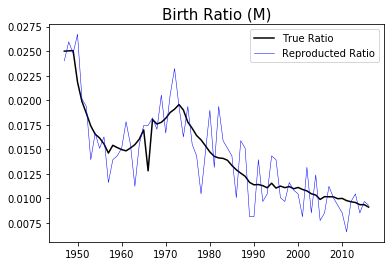

In [92]:
# 真の比率 vs. 擬似生成された誕生年の比率(男性のみ)を図で表現
# 真の誕生年比率
df_birth_M = df_birth.loc[df_birth.sex == 'M', ['year', 'ratio']]
df_birth_M['ratio'] = df_birth_M.ratio / df_birth_M.ratio.sum()
# 擬似生成された加入者の誕生年比率
df_info_M = df_info.loc[df_info.sex == 'M', ['birth_ym', 'family']]
df_info_M['birth_ym'] = df_info_M.birth_ym.apply(ym_to_t) // 1
df_info_M = df_info_M.groupby(['birth_ym']).count()
df_info_M = df_info_M / df_info_M.sum()
df_info_M
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df_birth_M.year, df_birth_M.ratio, c='k', label='True Ratio')
ax.plot(df_info_M.index, df_info_M.family, c='b',
label='Reproducted Ratio', lw=0.5)
ax.legend(loc='best')
ax.set_title('Birth Ratio (M)', fontsize=15)

## 観察期間と分析期間の概念図


Text(0.5, 1.0, 'Observation Period vs. Study Period')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


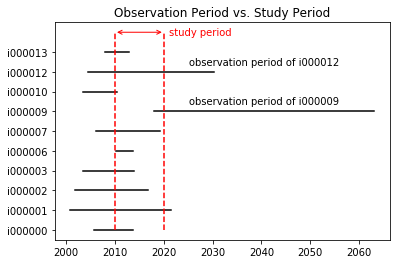

In [94]:
df = df_info.iloc[:10].copy()
df['start_obs_t'] = df.start_obs_ym.apply(ym_to_t)
df['end_obs_t'] = df.end_obs_ym.apply(ym_to_t)
fig = plt.figure()
ax = fig.add_subplot(111)
for i in df.index:
    X = df.loc[i, ['start_obs_t', 'end_obs_t']]
    Y = [i, i]
    ax.plot(X, Y, c='k')
ax.plot([start_study_t, start_study_t], [0, 10], c='r', ls='--')
ax.plot([end_study_t, end_study_t], [0, 10], c='r', ls='--')
ax.annotate('', xy=(end_study_t, 10), xytext=(start_study_t, 10),
arrowprops=dict(arrowstyle='<->', color='r'))
# 分析期間
x = end_study_t + 1
y = 10
t = 'study period'
ax.text(x, y, t, color='r', va='center', ha='left')
# iid = i000009 の観察期間
x = (df.loc[6, 'start_obs_t'] + df.loc[6, 'end_obs_t']) / 2
y = 6.5
t = 'observation period of i000009'
ax.text(x, y, t, color='k', va='center', ha='center')
# iid = i000012 の観察期間
y = 8.5
t = 'observation period of i000012'
ax.text(x, y, t, color='k', va='center', ha='center')
ax.set_yticks(df.index)
ax.set_yticklabels(df.iid)
ax.set_title('Observation Period vs. Study Period')

In [103]:
df_info['start_obs_t'] = df_info['start_obs_ym'].apply(ym_to_t)
# ---------------
# 時刻が文字列のままでも大小比較は可能ですが、
# 数値に変換しておくと次の年齢の計算で便利なので数値にすることとします。
more_start_study = (df_info['start_obs_t'] > start_study_t)
df_info['start_obs_t'] = more_start_study * df_info['start_obs_t'] \
+ ~more_start_study * start_study_t
# -----------------
# ~ は論理否定演算子、False→True, True→False, 0→1、1→0
df_info['start_obs_ym'] = df_info['start_obs_t'].apply(t_to_ym)
# 観察終了年月の分析終了時点での制限
df_info['end_obs_t'] = df_info['end_obs_ym'].apply(ym_to_t)
less_end_study = (df_info['end_obs_t'] < end_study_t)
df_info['end_obs_t'] = less_end_study * df_info['end_obs_t'] \
+ ~less_end_study * end_study_t
df_info['end_obs_ym'] = df_info['end_obs_t'].apply(t_to_ym)
df_info['birth_t'] = df_info['birth_ym'].apply(ym_to_t)

In [106]:
df_info.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,start_obs_t,end_obs_t,birth_t
0,i000000,M,1.0,1952/06,2010/01,2013/09,2010.041667,2013.708333,1952.458333
1,i000001,F,2.0,1972/11,2010/01,2019/12,2010.041667,2019.958333,1972.875000
2,i000002,M,1.0,1978/03,2010/01,2016/09,2010.041667,2016.708333,1978.208333
3,i000003,M,2.0,1989/03,2010/01,2013/12,2010.041667,2013.958333,1989.208333
4,i000006,M,1.0,1973/11,2010/04,2013/09,2010.291667,2013.708333,1973.875000


In [107]:
types = {'iid': 'str',
         'sex': 'str',
         'family': 'int8',
         'birth_ym': 'str',
         'start_obs_ym': 'str',
         'end_obs_ym': 'str',
         'start_obs_t': 'float32',
         'end_obs_t': 'float32',
         'birth_t': 'float32'}
df_info = df_info.astype(types)
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
iid             5000 non-null object
sex             5000 non-null object
family          5000 non-null int8
birth_ym        5000 non-null object
start_obs_ym    5000 non-null object
end_obs_ym      5000 non-null object
start_obs_t     5000 non-null float32
end_obs_t       5000 non-null float32
birth_t         5000 non-null float32
dtypes: float32(3), int8(1), object(5)
memory usage: 258.9+ KB


In [108]:
def create_npa_obs_ym(start_study_t, end_study_t):
    t = start_study_t
    obs_ym = []
    while t < end_study_t:
        ym = t_to_ym(t)
        obs_ym.append(ym)
        t = ym_to_t(ym) + 1/12
    return np.array(obs_ym)

# 一連の観察期間を時刻 t (スカラー) に変換。
def convert_ym_to_t_in_npa(npa_obs_ym):
    # np.array に apply がないため
    # pd.Series に一度変換して apply して np.array に戻す。
    return np.array(pd.Series(npa_obs_ym).apply(ym_to_t))

npa_obs_ym = create_npa_obs_ym(start_study_t, end_study_t)
npa_obs_t = convert_ym_to_t_in_npa(npa_obs_ym)
npa_birth_t = np.array(df_info['birth_t'])
df_alb_table = df_info.copy()

for i in np.arange(len(npa_obs_ym)):
    # "//" で商(整数)をとる。ちなみに剰余演算子は "%"
    # df_alb_table に新しい列を追加しながら、計算した ALB 列を代入している。
    df_alb_table[npa_obs_ym[i]] = (npa_obs_t[i] - npa_birth_t) // 1
    df_alb_table[npa_obs_ym[i]] = df_alb_table[npa_obs_ym[i]].astype('int8')

In [114]:
npa_birth_t

array([1952.4584, 1972.875 , 1978.2084, ..., 1987.125 , 1980.625 ,
       1952.4584], dtype=float32)

In [112]:
df_alb_table

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,67,67,67,67,67,67
1,i000001,F,2,1972/11,2010/01,2019/12,...,46,46,46,46,47,47
2,i000002,M,1,1978/03,2010/01,2016/09,...,41,41,41,41,41,41
3,i000003,M,2,1989/03,2010/01,2013/12,...,30,30,30,30,30,30
4,i000006,M,1,1973/11,2010/04,2013/09,...,45,45,45,45,46,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,i008255,M,1,1988/12,2010/01,2013/07,...,30,30,30,30,30,31
4996,i008259,M,1,2012/11,2010/01,2015/02,...,6,6,6,6,7,7
4997,i008260,M,1,1987/02,2019/06,2019/12,...,32,32,32,32,32,32
4998,i008263,M,1,1980/08,2010/01,2016/11,...,38,39,39,39,39,39


In [115]:
df_mortality = pd.read_csv('./public_stats/processed/ipss_mortality.csv')

In [116]:
df_mortality

,alb,F,M
0,0,0.000098,0.000097
1,1,0.000020,0.000022
2,2,0.000011,0.000013
3,3,0.000008,0.000010
4,4,0.000007,0.000008
...,...,...,...
95,95,0.019390,0.028668
96,96,0.021471,0.031293
97,97,0.023992,0.034089
98,98,0.027662,0.038338


In [119]:
df_mortality_table = df_alb_table.copy()

# int8 から float64 に変換することで、死亡率がより精緻に取り扱える。
for i in np.arange(len(npa_obs_ym)):
    df_mortality_table[npa_obs_ym[i]] = df_mortality_table[npa_obs_ym[i]].astype('float64')

# (sex, alb) に対応する月次死亡率を取得
def get_mortality(df_mortality, sex, alb):
    if alb < 0 or 100 <= alb:
        return 0
    else:
        return df_mortality.loc[alb, sex]
    
# df_mortality_table の ym 列に関する月次死亡率を np.array 形式で計算
def calc_monthly_mortality_col(df_mortality, df_alb_table, ym):
    sexes = df_alb_table['sex'] # 加入者の性別一覧
    albs = df_alb_table[ym] # 加入者の "yyyy/mm" における満年齢一覧
    mortalities = [get_mortality(df_mortality, sex, alb) for (sex, alb) in zip(sexes, albs)] # リスト内包表記
    # np.isnan の使用と、月次死亡率計算でブロードキャスティングを使うため
    # リスト形式を np.array 形式に変換。
    # ブロードキャスティングについては以下を参照。
    # https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
    mortalities = np.array(mortalities)
    mortalities[np.isnan(mortalities)] = 0
    return mortalities

# df_mortality_table に月次死亡率を埋める
for ym in npa_obs_ym:
    mortalities = calc_monthly_mortality_col(df_mortality, df_alb_table, ym)
    df_mortality_table[ym] = mortalities

In [122]:
assert df_mortality_table.shape == df_alb_table.shape

In [124]:
# 通常エクスポージャは [人年] で計算されるが
# ここでは単位を [人月] とする。
df_exposure_table = df_alb_table.copy()
for ym in npa_obs_ym:
    # Boolean values for Start_obs_t
    bs = (df_exposure_table['start_obs_t'] <= ym_to_t(ym))
    # Boolean values for End_obs_t
    be = (ym_to_t(ym) <= df_exposure_table['end_obs_t'])
    # Boolean values for Birth_t
    bb = (df_exposure_table['birth_t'] <= ym_to_t(ym))
    # Boolean values for ALB
    # 健保組合は65歳以上を保障しない
    ba = (df_alb_table[ym] < 65)
    df_exposure_table[ym] = (bs & be & bb & ba) * 1

In [126]:
assert df_exposure_table.shape == df_alb_table.shape

死亡状態のテーブル作成

In [129]:
df_death_table = df_alb_table.copy()
rs = 0 # rs: Random Seed
np.random.seed(rs) # 乱数シードをセット
df_random = np.random.random(df_death_table[npa_obs_ym].shape)
df_death_table[npa_obs_ym] = (df_random < df_mortality_table[npa_obs_ym]) * df_exposure_table[npa_obs_ym] * 1

In [131]:
df_death_table[npa_obs_ym]

,2010/01,2010/02,2010/03,2010/04,2010/05,2010/06,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,0,0,0,0,0,0,...,0,0,0,0,0,0
1,0,0,0,0,0,0,...,0,0,0,0,0,0
2,0,0,0,0,0,0,...,0,0,0,0,0,0
3,0,0,0,0,0,0,...,0,0,0,0,0,0
4,0,0,0,0,0,0,...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,...,0,0,0,0,0,0
4996,0,0,0,0,0,0,...,0,0,0,0,0,0
4997,0,0,0,0,0,0,...,0,0,0,0,0,0
4998,0,0,0,0,0,0,...,0,0,0,0,0,0


In [133]:
pd.options.display.max_rows = 20
print(df_death_table.iloc[17].iid, '\n')
df_death_table.loc[17, npa_obs_ym[12:]].head(10)

i000027 



2011/01    0
2011/02    0
2011/03    0
2011/04    1
2011/05    0
2011/06    0
2011/07    0
2011/08    0
2011/09    0
2011/10    0
Name: 17, dtype: object

In [134]:
# cumsum を2回適用して、1となるセルのみを1とし、それ以外を0とする。
df_death_table[npa_obs_ym] = (df_death_table[npa_obs_ym].cumsum(axis=1).cumsum(axis=1) == 1) * 1
# 整数型に変更してメモリ効率を上げる。
for i in np.arange(len(npa_obs_ym)):
    df_death_table[npa_obs_ym[i]] = df_death_table[npa_obs_ym[i]].astype('int8')
# 死亡後のエクスポージャを0に変更。
before_death_filter = (df_death_table[npa_obs_ym].cumsum(axis=1).cumsum(axis=1) <= 1) * 1
df_exposure_table[npa_obs_ym] = df_exposure_table[npa_obs_ym] * before_death_filter

In [135]:
df_exposure_table

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,0,0,0,0,0,0
1,i000001,F,2,1972/11,2010/01,2019/12,...,1,1,1,1,1,1
2,i000002,M,1,1978/03,2010/01,2016/09,...,0,0,0,0,0,0
3,i000003,M,2,1989/03,2010/01,2013/12,...,0,0,0,0,0,0
4,i000006,M,1,1973/11,2010/04,2013/09,...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,i008255,M,1,1988/12,2010/01,2013/07,...,0,0,0,0,0,0
4996,i008259,M,1,2012/11,2010/01,2015/02,...,0,0,0,0,0,0
4997,i008260,M,1,1987/02,2019/06,2019/12,...,1,1,1,1,1,1
4998,i008263,M,1,1980/08,2010/01,2016/11,...,0,0,0,0,0,0


In [136]:
df_info

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,start_obs_t,end_obs_t,birth_t
0,i000000,M,1,1952/06,2010/01,2013/09,2010.041626,2013.708374,1952.458374
1,i000001,F,2,1972/11,2010/01,2019/12,2010.041626,2019.958374,1972.875000
2,i000002,M,1,1978/03,2010/01,2016/09,2010.041626,2016.708374,1978.208374
3,i000003,M,2,1989/03,2010/01,2013/12,2010.041626,2013.958374,1989.208374
4,i000006,M,1,1973/11,2010/04,2013/09,2010.291626,2013.708374,1973.875000
...,...,...,...,...,...,...,...,...,...
4995,i008255,M,1,1988/12,2010/01,2013/07,2010.041626,2013.541626,1988.958374
4996,i008259,M,1,2012/11,2010/01,2015/02,2010.041626,2015.125000,2012.875000
4997,i008260,M,1,1987/02,2019/06,2019/12,2019.458374,2019.958374,1987.125000
4998,i008263,M,1,1980/08,2010/01,2016/11,2010.041626,2016.875000,1980.625000


In [137]:
df_info['death'] = 0
df_info['death'] = df_info['death'].astype('int8')
df_info.loc[(df_death_table[npa_obs_ym].sum(axis=1) == 1), 'death'] = 1

In [138]:
df_info

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,start_obs_t,end_obs_t,birth_t,death
0,i000000,M,1,1952/06,2010/01,2013/09,2010.041626,2013.708374,1952.458374,0
1,i000001,F,2,1972/11,2010/01,2019/12,2010.041626,2019.958374,1972.875000,0
2,i000002,M,1,1978/03,2010/01,2016/09,2010.041626,2016.708374,1978.208374,0
3,i000003,M,2,1989/03,2010/01,2013/12,2010.041626,2013.958374,1989.208374,0
4,i000006,M,1,1973/11,2010/04,2013/09,2010.291626,2013.708374,1973.875000,0
...,...,...,...,...,...,...,...,...,...,...
4995,i008255,M,1,1988/12,2010/01,2013/07,2010.041626,2013.541626,1988.958374,0
4996,i008259,M,1,2012/11,2010/01,2015/02,2010.041626,2015.125000,2012.875000,0
4997,i008260,M,1,1987/02,2019/06,2019/12,2019.458374,2019.958374,1987.125000,0
4998,i008263,M,1,1980/08,2010/01,2016/11,2010.041626,2016.875000,1980.625000,0


In [139]:
# 当月のエクスポージャが 1、翌月のエクスポージャが0の時
# 当月が観察終了年月となる。
# エクスポージャを 1 ヶ月ずらした差分が 1 となる年月が観察最終年月。
df_exp_dif = df_exposure_table[npa_obs_ym] \
- df_exposure_table[npa_obs_ym].shift(-1, axis=1)
# ただし分析終了年月の翌月は存在しないため None となる。
# 分析終了年月 (2019/12) にエクスポージャが 1 の場合
# 分析終了年月年月が観察終了年月となる。
df_exp_dif[npa_obs_ym[-1]] = df_exposure_table[npa_obs_ym[-1]]
# 差分が -1 の箇所を 0 に変更。
df_exp_dif[df_exp_dif < 0] = 0

In [140]:
df_exp_dif

,2010/01,2010/02,2010/03,2010/04,2010/05,2010/06,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0
4996,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0
4997,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1
4998,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0


In [144]:
exposure_exists = (df_exposure_table[npa_obs_ym].sum(axis=1) > 0)
df_info = df_info[exposure_exists]

In [146]:
df_exposure_table = df_exposure_table[exposure_exists]

In [149]:
b = (df_info['start_obs_ym'] < df_info['birth_ym'])
df_info.loc[b, 'birth_ym'] = df_info.loc[b, 'start_obs_ym']
df_info.loc[b, 'birth_t'] = df_info.loc[b, 'start_obs_t']

/home/kimoton/miniconda3/envs/data_analysis/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [150]:
# エクスポージャの最終年月を観察終了年月とする。
for i in df_exposure_table.index:
    end_of_exp = (df_exp_dif.loc[i, npa_obs_ym] == 1)
    df_info.loc[i, 'end_obs_ym'] = npa_obs_ym[end_of_exp][0]
# 時刻 t に関する情報を削除し、カラムを並べ替える。
info_cols = ['iid', 'sex', 'family', 'birth_ym',
             'start_obs_ym', 'end_obs_ym', 'death']
df_info = df_info[info_cols]

In [153]:
npa_obs_ym[end_of_exp]

array(['2010/10'], dtype='<U7')

In [154]:
del df_birth
del df_mortality
del df_exposure
del df_alb_table
del df_mortality_table
del df_exposure_table
del df_death_table
gc.collect()

8095

In [156]:
!mkdir -p ./pseudo_medical/records/excl_bp

In [157]:
df_info.to_csv('./pseudo_medical/records/excl_bp/info.csv', index=False)